# ElasticNet Inventory Forecasting + Dashboard

This notebook runs an end-to-end ElasticNet pipeline on `retail_store_inventory.csv` and creates a small dashboard with:
1. Time-series actual vs predicted (if date column exists)
2. Predicted vs Actual scatter + y=x line
3. Residuals histogram and residuals vs predicted scatter
4. Bar chart of top ElasticNet coefficients (absolute value)

Place `retail_store_inventory.csv` in the same directory or in `/mnt/data/` and run the cells.


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from math import sqrt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from google.colab import drive
drive.mount('/content/drive/')

print('Libraries loaded')

Mounted at /content/drive/
Libraries loaded


In [ ]:
#DATA_PATHS = ["retail_store_inventory.csv", "/mnt/data/retail_store_inventory.csv"]
DATA_PATH = '/content/drive/MyDrive/data/retail_store_inventory.csv'
if DATA_PATH is None:
    raise FileNotFoundError(f"Dataset not found in {DATA_PATHS}. Place 'retail_store_inventory.csv' in notebook directory or /mnt/data.")
OUT_MODEL = "/mnt/data/elasticnet_retail_model.joblib"
TOP_K_COEFS = 20
print('Using dataset:', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)
display(df.head(8))
df.columns = [c.strip() for c in df.columns]


Using dataset: /content/drive/MyDrive/data/retail_store_inventory.csv
Dataset shape: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring


In [ ]:
# --- Detect target and date column safely (fixed version) ---

# Preferred target names (edit if needed)
preferred_targets = [
    'Units Sold', 'Units_Sold', 'Units sold',
    'Inventory Level', 'Inventory_Level',
    'Demand Forecast', 'Sales', 'Quantity'
]

target_col = None

# Try to find a matching target column
for t in preferred_targets:
    if t in df.columns:
        target_col = t
        break

# If none found, choose a numeric column with the highest variance (as fallback)
if target_col is None:
    numeric_cols_tmp = df.select_dtypes(include=[np.number]).columns.tolist()
    likely_id = [c for c in numeric_cols_tmp if c.lower().startswith('id') or c.lower().endswith('id')]
    nums = [c for c in numeric_cols_tmp if c not in likely_id]
    if not nums:
        raise ValueError("No numeric column found for target. Please set `target_col` manually.")
    target_col = max(nums, key=lambda c: df[c].var())

print("✅ Selected target column:", target_col)

# --- Detect date column ---
date_col = None
for c in df.columns:
    if 'date' in c.lower():
        try:
            df[c] = pd.to_datetime(df[c], errors='coerce')
            if df[c].notna().sum() > 0:
                date_col = c
                break
        except Exception:
            pass  # skip if parse fails

# Fallback for 'Date' named column
if date_col is None and 'Date' in df.columns:
    try:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        if df['Date'].notna().sum() > 0:
            date_col = 'Date'
    except Exception:
        date_col = None

print("✅ Detected date column:", date_col)


✅ Selected target column: Units Sold
✅ Detected date column: Date


In [ ]:
# Basic cleaning, lags, rolling features
id_like = [c for c in df.columns if c.lower() in ('id','sku','item_id','product_id','store id','store_id') or c.lower().endswith('_id')]
id_like = [c for c in id_like if c in df.columns]
if id_like:
    df = df.drop(columns=id_like)
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()
group_candidates = [c for c in df.columns if any(x in c.lower() for x in ('store','item','product','sku','outlet','shop'))]
group_col = group_candidates[0] if group_candidates else None
working = df.copy()
if date_col:
    working = working.sort_values(by=date_col).reset_index(drop=True)
LAGS = [1,2,3,7]
ROLLS = [3,7]
for lag in LAGS:
    if group_col:
        working[f'lag_{lag}'] = working.groupby(group_col)[target_col].shift(lag)
    else:
        working[f'lag_{lag}'] = working[target_col].shift(lag)
for w in ROLLS:
    if group_col:
        working[f'roll_mean_{w}'] = working.groupby(group_col)[target_col].shift(1).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
    else:
        working[f'roll_mean_{w}'] = working[target_col].shift(1).rolling(window=w, min_periods=1).mean()
working = working.dropna(subset=[f'lag_{LAGS[0]}']).reset_index(drop=True)
y = working[target_col].astype(float)
X = working.drop(columns=[target_col])
if date_col and date_col in X.columns:
    X = X.drop(columns=[date_col])
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if not pd.api.types.is_bool_dtype(X[c])]
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print('Numeric cols:', len(numeric_cols), 'Categorical cols:', len(categorical_cols))


Numeric cols: 13 Categorical cols: 5


In [ ]:
# Train/test split
if date_col:
    split_idx = int(len(working) * 0.8)
    X_train, X_test = X.iloc[:split_idx].copy(), X.iloc[split_idx:].copy()
    y_train, y_test = y.iloc[:split_idx].copy(), y.iloc[:split_idx].copy()
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])


Train size: 58464 Test size: 14616


In [ ]:
# Preprocessing and ElasticNet GridSearch (fixed OneHotEncoder compatibility)

# Build a OneHotEncoder instance that works across sklearn versions
from sklearn.preprocessing import OneHotEncoder
try:
    # older sklearn: supports `sparse` argument
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
except TypeError:
    # newer sklearn: `sparse` removed, use `sparse_output` instead
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorical transformer uses the compatible OneHotEncoder instance
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

# combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# pipeline & grid (unchanged)
pipeline = Pipeline(steps=[('preproc', preprocessor), ('model', ElasticNet(max_iter=5000))])
param_grid = {'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1], 'model__l1_ratio': [0.1, 0.5, 0.9]}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
best_model = grid.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.9}


In [ ]:
# --- Recreate time-based split and evaluate (no retrain) ---
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure `working`, `X`, `y`, `best_model` exist in the notebook
try:
    len_working = len(working)
except NameError:
    raise RuntimeError("`working` dataframe not found. Run the feature-engineering cell that creates `working`, `X`, and `y` first.")

# Recompute split
split_idx = int(len_working * 0.8)
X_train = X.iloc[:split_idx].copy()
X_test = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_test = y.iloc[split_idx:].copy()

print("Recreated split sizes ->", "X_train:", len(X_train), "X_test:", len(X_test), "y_train:", len(y_train), "y_test:", len(y_test))

# Reset indices to avoid any index misalignment
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Predict and evaluate
y_pred = best_model.predict(X_test)
print("y_pred length:", len(y_pred), "y_test length:", len(y_test))

# --- Safer error metrics (robust MAPE & SMAPE) ---
def safe_mape(y_true, y_pred, min_actual=5.0):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), min_actual)  # clamp tiny actuals
    return 100.0 * np.mean(np.abs(y_true - y_pred) / denom)

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) /
                           (np.abs(y_true) + np.abs(y_pred) + 1e-8))

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mape_robust = safe_mape(y_test, y_pred, min_actual=5.0)
smape_score = smape(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance (recomputed split):")
print(f"MAE:   {mae:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAPE*: {mape_robust:.2f}%  (robust to zeros; min_actual=5)")
print(f"SMAPE: {smape_score:.2f}%")
print(f"R2:    {r2:.4f}")




Recreated split sizes -> X_train: 58464 X_test: 14616 y_train: 58464 y_test: 14616
y_pred length: 14616 y_test length: 14616

Test set performance (recomputed split):
MAE:   7.5225
RMSE:  8.6996
MAPE*: 17.65%  (robust to zeros; min_actual=5)
SMAPE: 17.60%
R2:    0.9935


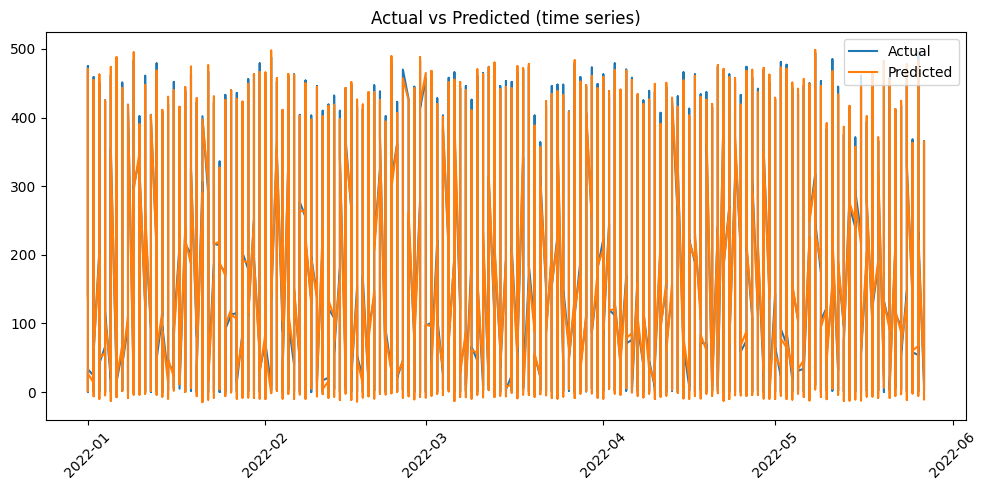

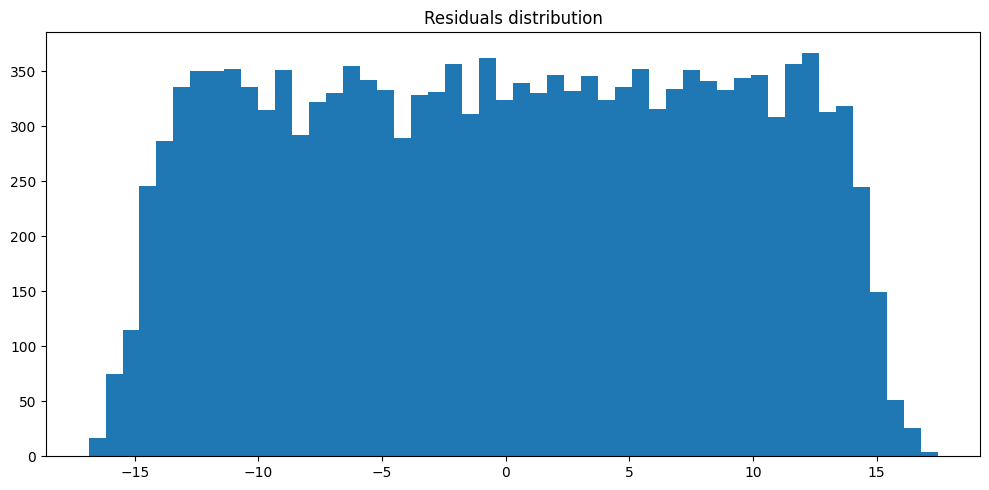

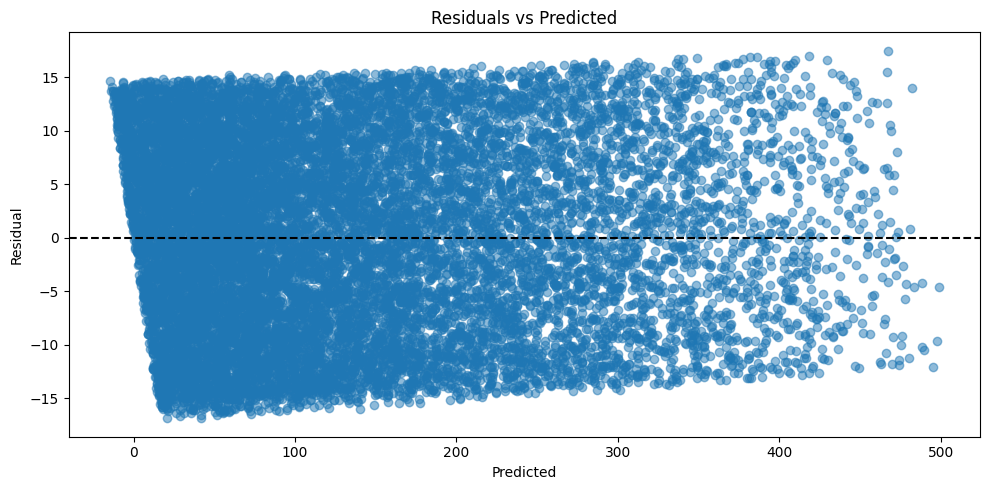

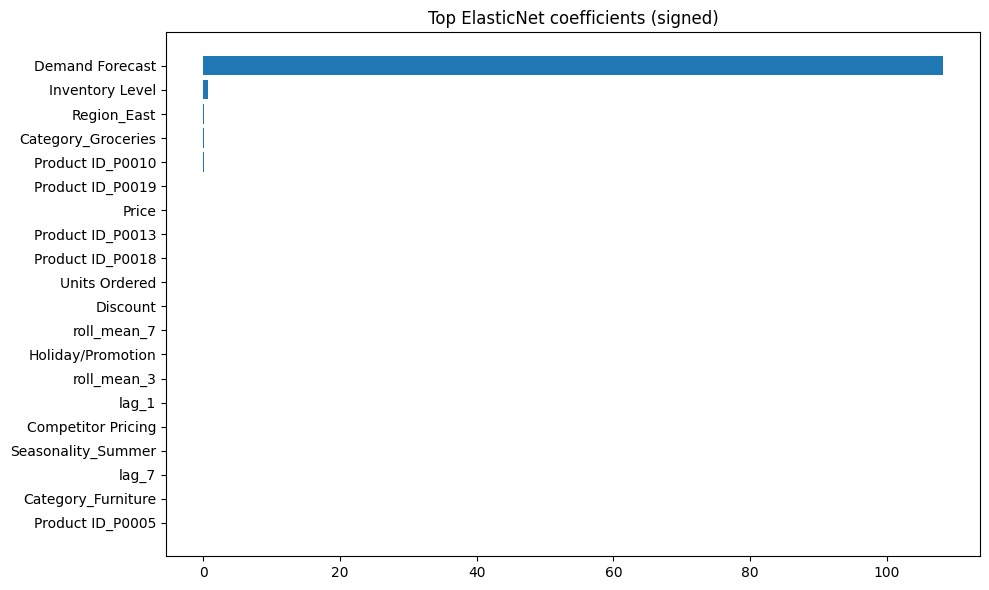

In [ ]:
# Dashboard plots
plt.rcParams['figure.figsize'] = (10,5)

# If date exists and is in original working frame, plot time series
if 'Date' in df.columns or date_col:
    # try to find a date index for the test portion
    try:
        if date_col:
            dates = working.reset_index().iloc[X_test.index][date_col]
        elif 'Date' in df.columns:
            dates = working.reset_index().iloc[X_test.index]['Date']
        else:
            dates = None
    except Exception:
        dates = None
else:
    dates = None

if dates is not None:
    plt.figure()
    plt.plot(dates, y_test.values, label='Actual')
    plt.plot(dates, y_pred, label='Predicted')
    plt.title('Actual vs Predicted (time series)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
else:
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.5)
    mn = min(min(y_test), min(y_pred))
    mx = max(max(y_test), max(y_pred))
    plt.plot([mn,mx],[mn,mx], color='k', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual (scatter)')
    plt.tight_layout()

# Residuals
residuals = y_test.values - y_pred
plt.figure()
plt.hist(residuals, bins=50)
plt.title('Residuals distribution')
plt.tight_layout()

plt.figure()
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted')
plt.tight_layout()

# Feature importance (coefficients)
try:
    feat_names = best_model.named_steps['preproc'].get_feature_names_out()
    coefs = best_model.named_steps['model'].coef_
    coef_df = pd.DataFrame({'feature': feat_names, 'coef': coefs})
    coef_df['abs_coef'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False).head(TOP_K_COEFS)
    plt.figure(figsize=(10,6))
    plt.barh(coef_df['feature'][::-1], coef_df['coef'][::-1])
    plt.title('Top ElasticNet coefficients (signed)')
    plt.tight_layout()
except Exception as e:
    print('Could not compute coefficient chart:', e)


## End of notebook

You can rerun cells, adjust LAGS/ROLLS/param_grid/TOP_K_COEFS, or add SHAP analysis (install `shap`) for deeper interpretability.